In [6]:
import pandas as pd
from src.ticket_messages import TicketMessage

In [7]:
df = pd.read_parquet("data/classification_dataset")

In [8]:
df.tail()

,account_id,ticket_id,raw_body,channel,unix_timestamp,contact_reason,processed_body,email_sentence_embeddings
56167,47355,97704266,-7329393197999221857,email,1.683747e+09,"""Pre-sale::Place an order""",7769862566240229096,"{""7076610397638084948"": [0.04829759523272514, ..."
56168,47355,97104492,-712526401448959206,email,1.683821e+09,"""No Action Req::Others""",8225526187121867386,"{""-4707052099692602634"": [0.04418250918388367,..."
56169,47355,98114244,-6396575246795551664,email,1.683823e+09,"""No Action Req::Others""",0,None
56170,47355,98375668,8956876459394868202,email,1.684164e+09,"""Tech Supp::Tech_Query""",4884952985295307657,"{""-6790423425691970518"": [-0.10473562777042389..."
56171,47355,98834917,3230166170796936168,email,1.684271e+09,"""Shipping::Tracking""",1023372247625818182,"{""1824102601729972162"": [-0.02185063622891903,..."


In [9]:
ticket_message_list = TicketMessage.from_dataframe(dataframe=df)

In [10]:
i = 13524

print(f"Account id = {ticket_message_list[i].account_id}")
print(f"Ticket id = {ticket_message_list[i].ticket_id}")
print(f"Contact Reason = ", ticket_message_list[i].contact_reason)
if ticket_message_list[i].email_sentence_embeddings:
    print(f"Number of sentences in email = ", len(ticket_message_list[i].email_sentence_embeddings))
else:
    print(f"Number of sentences in email = ", 0)

Account id = 4453
Ticket id = 375526423
Contact Reason =  "Post-purchase::Other::Other"
Number of sentences in email =  3


# Journey (ML project lifecycle)

The journey consists of the following essential steps:

- **Scope**: Understand the project scope and business needs.
- **Data**: Understand the given data by conducting exploration data analysis (EDA)
  - Explore the dependent variable (target).
  - Explore the independent variables (features).
- **Modeling**: Build a proof of concept solution (PoC)
  - Select and train model.
  - Perform error analysis.
- **Deployment**: Deploy the PoC solution
  - Deploy model or models into production using FastAPI.
  - Monitor & maintain production system.

## Scope: Project Overview

- At Gorgias, we handle merchant customer tickets and provide a software platform that allows the tagging of tickets with the customer contact reason. 
Each client has a **unique set of contact reasons**, making building a flexible and adaptable classification system essential.

- Automating the classification of these tickets based on merchant-specific contact reasons can significantly improve efficiency and enhance customer support.

- This project aims to develop a machine-learning solution to automate the classification of merchant customer tickets based on their contact reasons. 

- Please bear in mind that the final solution would handle about 250K tickets on a daily basis with an expected response time of around 200ms.

## Data: Exploration data analysis (EDA)

In [88]:
# import necessary libs

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud, STOPWORDS

%config InlineBackend.figure_format='retina'
%matplotlib inline

## Data info
- **account_id**: str, Unique merchant ID.
- **ticket_id**: str, Unique ticket ID.
- **raw_body**: str, Hashed representation of the received message.
- **channel**: str, Channel from which the message was received (in this case, emails).
- **unix_timestamp**: float, Timestamp indicating when the ticket was created.
- **contact_reason**: str, the contact reason label associated with the message.
- **processed_body**: str, Hashed representation of the message after processing.
- **email_sentence_embeddings**: str, JSON string format containing a dictionary of hashed extracted sentences from the email and their embeddings.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56172 entries, 0 to 56171
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   account_id                 56172 non-null  object 
 1   ticket_id                  56172 non-null  object 
 2   raw_body                   56172 non-null  int64  
 3   channel                    56172 non-null  object 
 4   unix_timestamp             56172 non-null  float64
 5   contact_reason             56172 non-null  object 
 6   processed_body             56172 non-null  int64  
 7   email_sentence_embeddings  50719 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.4+ MB


## Target variable info

In [15]:
df.contact_reason.unique().shape[0]

1776

In [25]:
client_agg = df.groupby("account_id")
client_agg.size().shape[0]

67

There are **1776** unique labels associated with the email messages distributed across **67** unique clients that are presented in the data

In [33]:

client_agg_cnt = client_agg.contact_reason.apply(lambda x: x.unique().shape[0]) \
                           .to_frame("#_contact_reasons_per_client") \
                           .sort_values("#_contact_reasons_per_client")

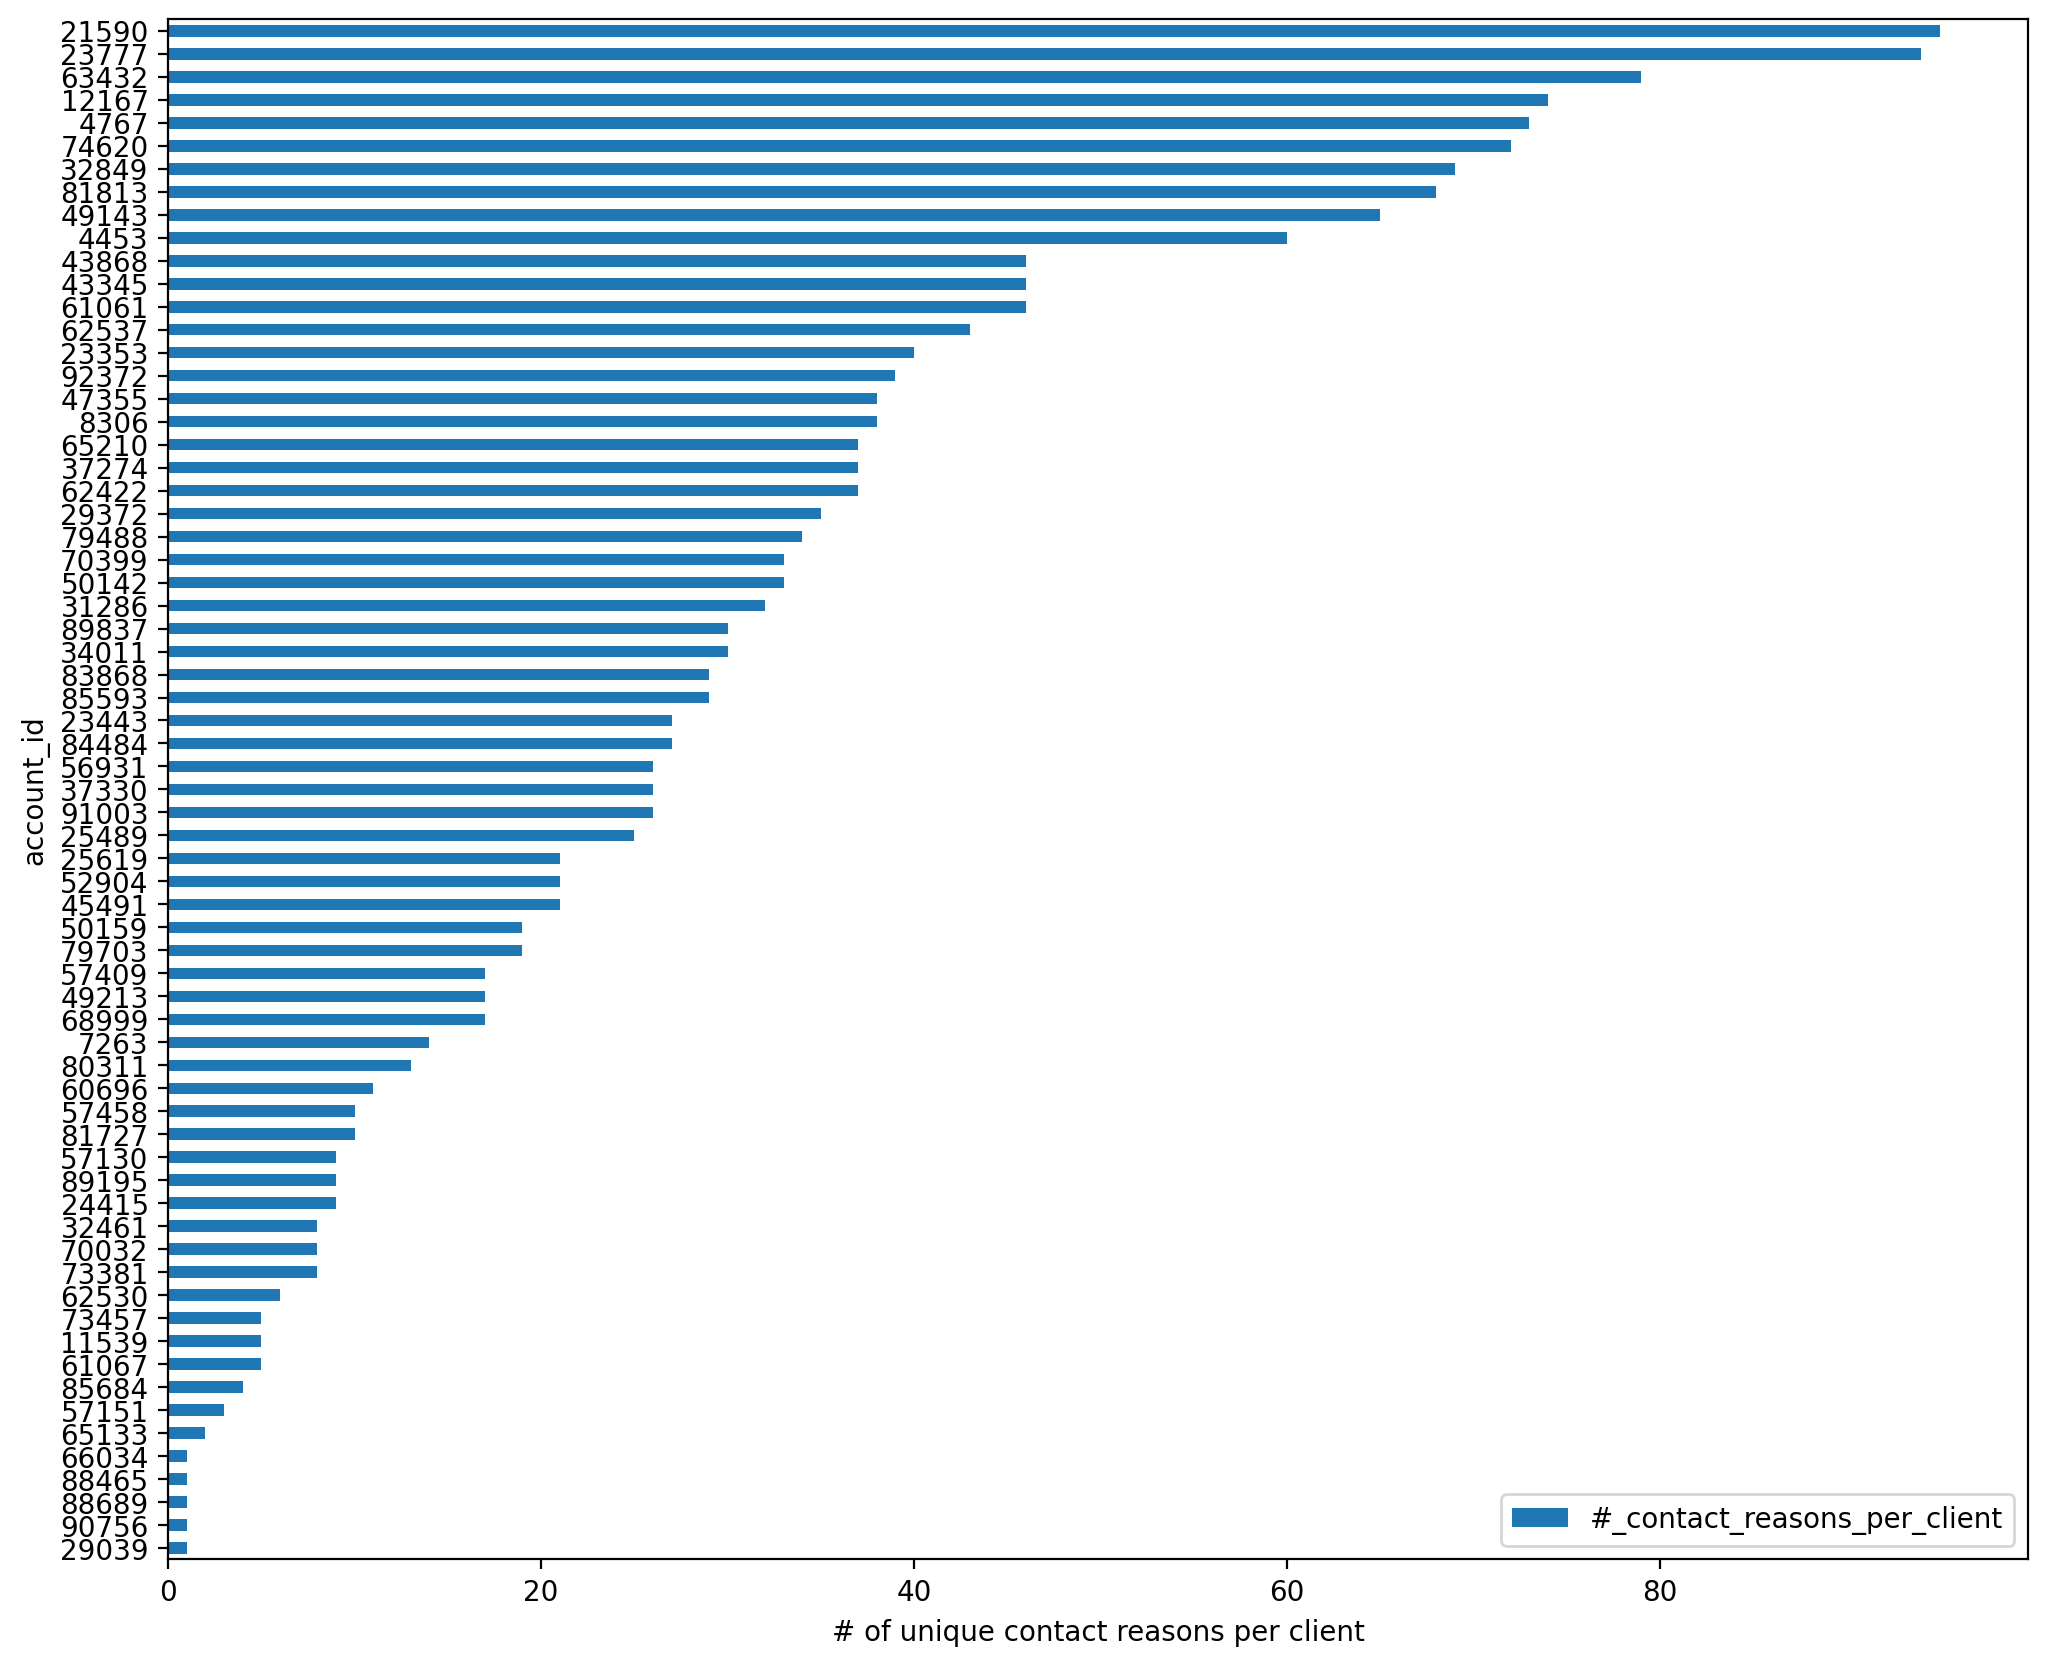

In [39]:
client_agg_cnt.plot(kind='barh', xlabel="# of unique contact reasons per client", figsize=(12, 10))
plt.show()

The figure shows the number of unique contact reasons per client. The distribution is quite skewed so we have clients with very few number of unique labels.

In [40]:
client_agg_cnt.head(10)

,#_contact_reasons_per_client
account_id,
29039,1
90756,1
88689,1
88465,1
66034,1
65133,2
57151,3
85684,4
61067,5


The following clients *29039*, *90756*, *88689*, *88465*, *66034* have only one contact reason. This needs to be considered in a PoC.

In [41]:
client_agg_set = client_agg.contact_reason.apply(lambda x: set(x))

In [ ]:
top_client_ids = client_agg_cnt.tail(10).index.tolist()

In [187]:
all_client_ids = client_agg_cnt.index.tolist()
common_labels = set()

for account_id1 in all_client_ids:
    for account_id2 in all_client_ids:
        if account_id1 != account_id2:
            overlap_set = client_agg_set[account_id1].intersection(client_agg_set[account_id2])
            n_overlaps = len(overlap_set)
            if n_overlaps > 0:
                common_labels = common_labels.union(overlap_set)
                # print(f"There are {n_overlaps} overlaps in labels for the clients {account_id1} and {account_id2}")
                # print(overlap_set)
                # print("-----")

len(common_labels)

67

In [188]:
list(common_labels)[:10]

['"Damaged Order"',
 '"Wholesale"',
 '"Fulfillment::Order Status"',
 '"Pre-Sales"',
 '"Others"',
 '"Return"',
 '"Exchange"',
 '"Shipping::Other"',
 '"Return::Refund"',
 '"Social"']

From the description we have that each client has a **unique set of contact reasons**, however some of the clients share **67** out of **1776** contact reasons such as "Other", "Cancel order" and "Social Media". Coincidence? :)

In [98]:
client_agg_list = client_agg.contact_reason.apply(lambda x: x.tolist())

In [100]:
wc = WordCloud(stopwords=STOPWORDS, max_words=100, width=800, height=400)

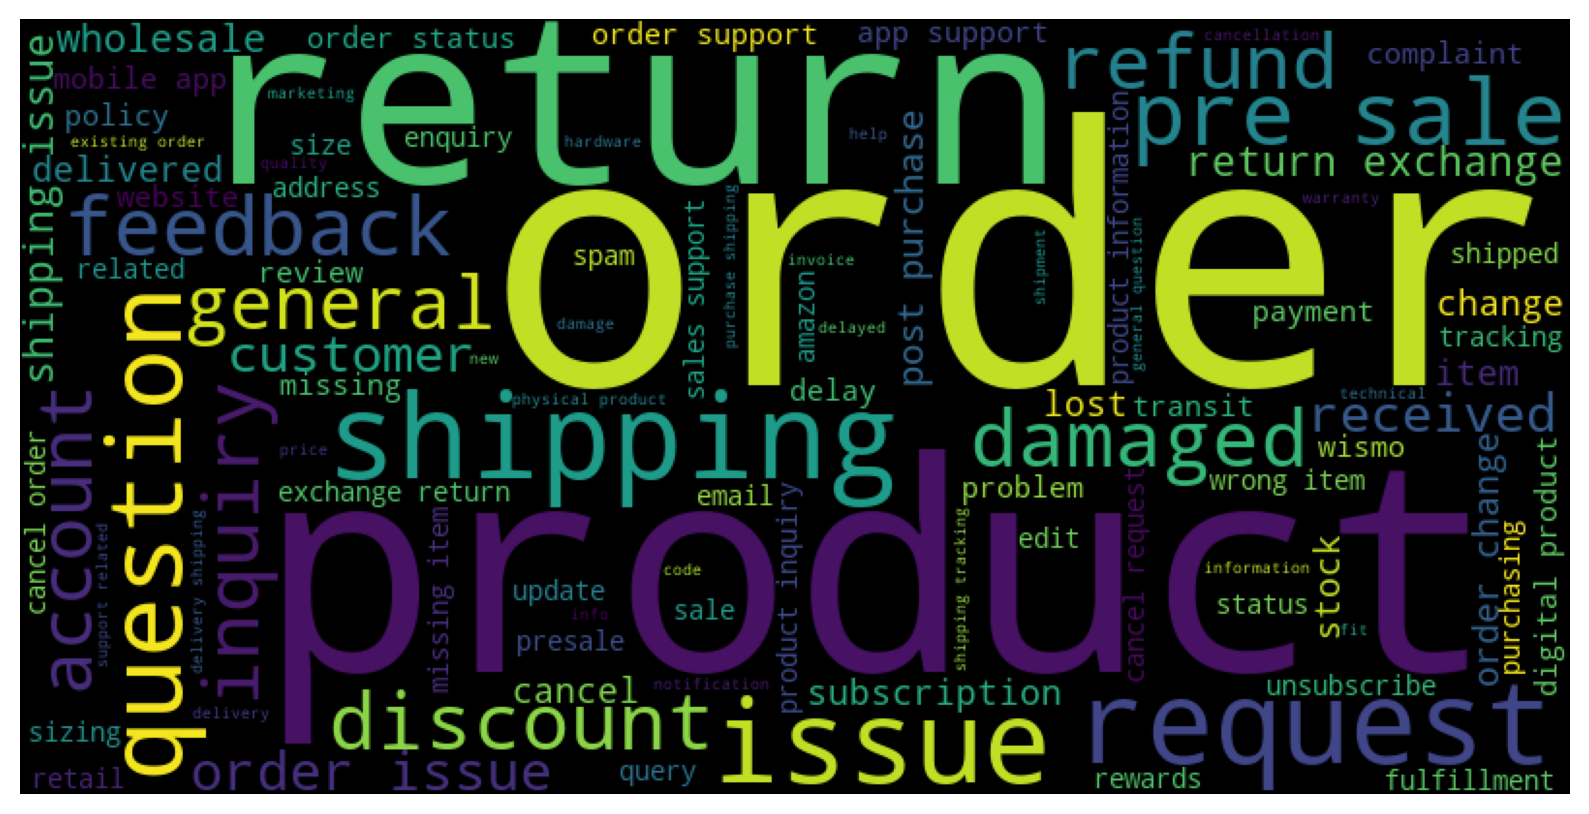

In [103]:
plt.figure(figsize=(10, 6))
contact_reasons = np.concatenate([l for l in client_agg_list.values])
contact_reasons = np.unique(contact_reasons).tolist()
wc.generate(' '.join([w.replace('"', '').lower() for w in contact_reasons]))
plt.axis("off")
plt.imshow(wc)
plt.show()

WordCloud helps better understand the general overview of the contact reason labels per client. As I might observe from the figure that the majority of contact reasons are related to **shipping**, **order** and **return** of a **product**.

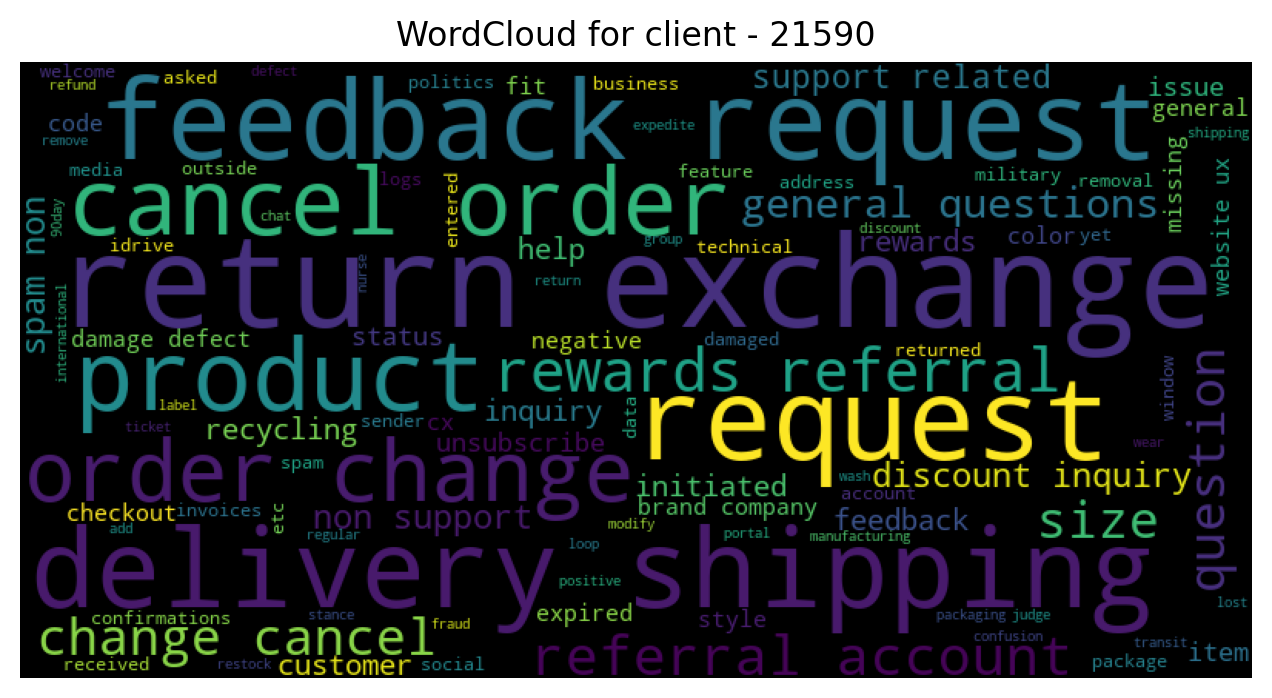

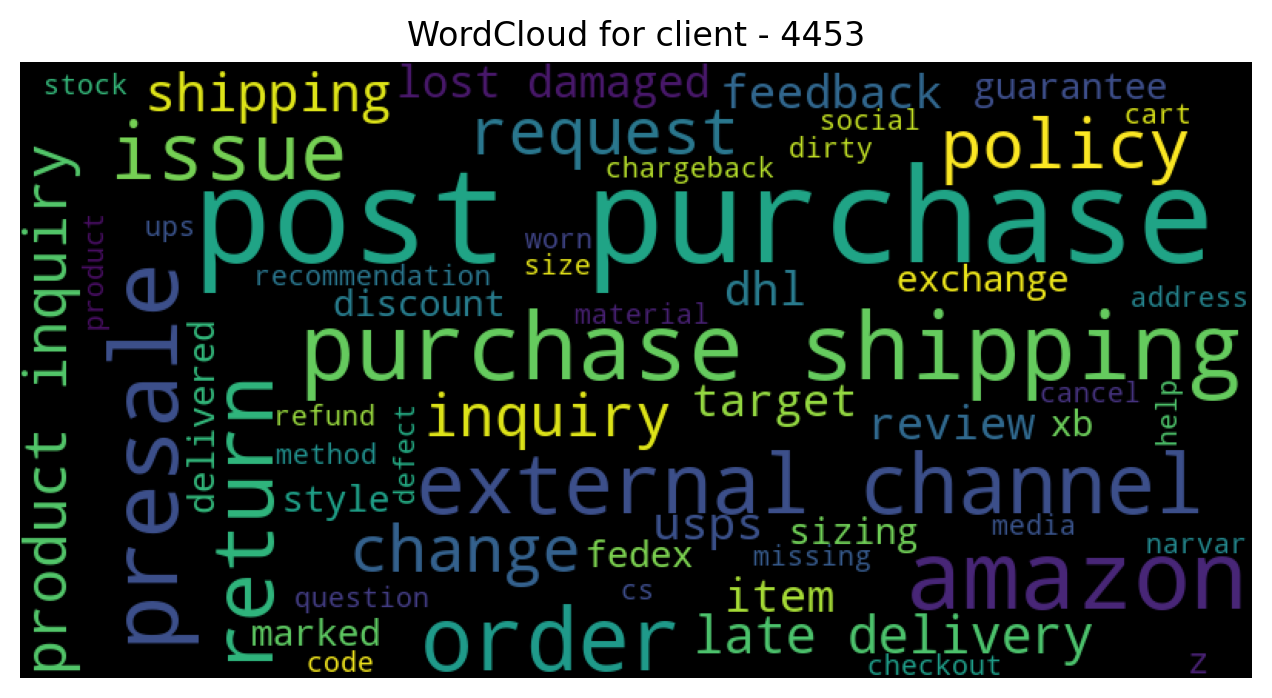

In [109]:
plt.figure(figsize=(8, 4))
contact_reasons = np.concatenate([l for l in client_agg_list[client_agg_list.index == top_client_ids[-1]].values])
contact_reasons = np.unique(contact_reasons).tolist()
wc.generate(' '.join([w.replace('"', '').lower() for w in contact_reasons]))
plt.axis("off")
plt.title(f"WordCloud for client - {top_client_ids[-1]}")
plt.imshow(wc)
plt.show()

plt.figure(figsize=(8, 4))
contact_reasons = np.concatenate([l for l in client_agg_list[client_agg_list.index == top_client_ids[0]].values])
contact_reasons = np.unique(contact_reasons).tolist()
wc.generate(' '.join([w.replace('"', '').lower() for w in contact_reasons]))
plt.axis("off")
plt.title(f"WordCloud for client - {top_client_ids[0]}")
plt.imshow(wc)
plt.show()

WordClouds with unique set of contact reasons for the top first and 10th clients. 

In [112]:
client_agg_ticket_cnt = client_agg.size().to_frame("#_tickets_per_client")

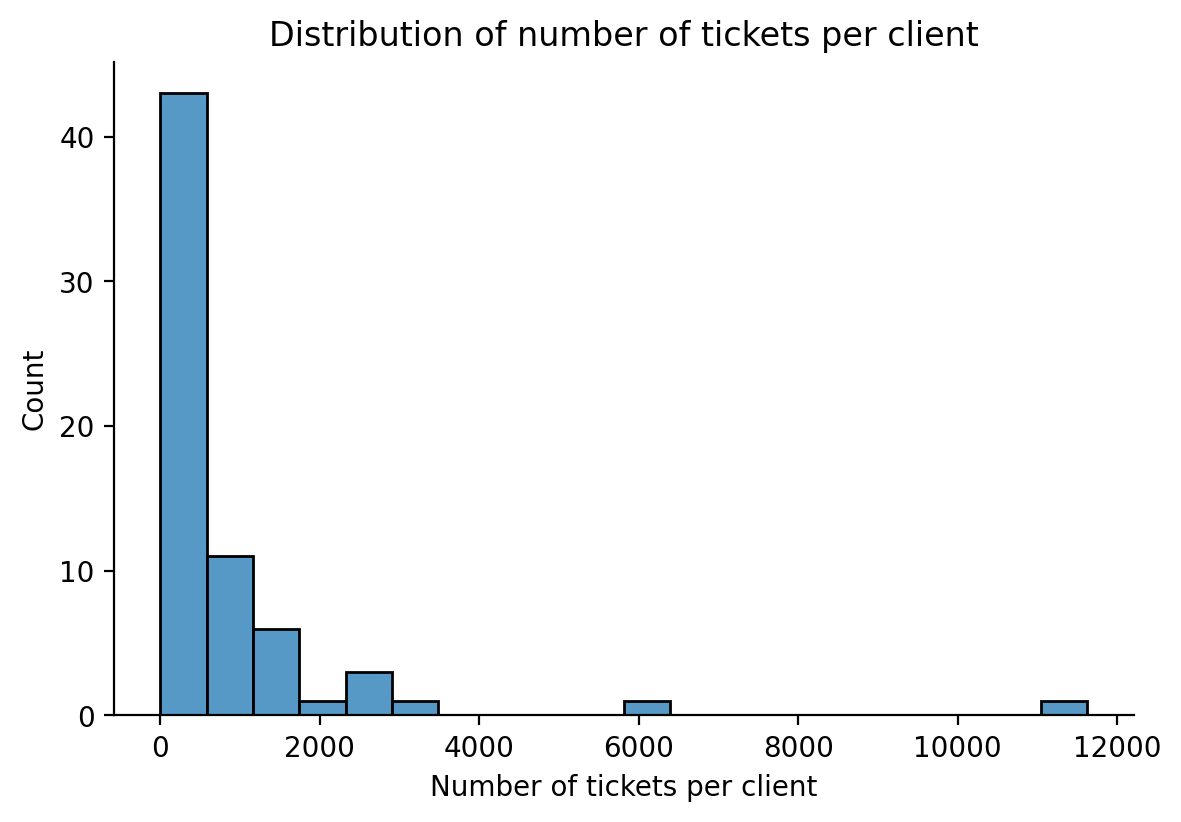

In [125]:
sns.displot(data=client_agg_ticket_cnt, x="#_tickets_per_client", bins=20, aspect=1.5, height=4)
plt.xlabel("Number of tickets per client")
plt.title("Distribution of number of tickets per client")
plt.show()

The number of tickets per client is also skewed so it needs to be considered in a PoC as well.

In [127]:
client_label_agg = df.groupby(["account_id", "contact_reason"])

In [149]:
client_label_agg_cnt = client_label_agg.size() \
                                       .to_frame("num_tickets") \
                                       .reset_index() \
                                       .sort_values(["account_id", "num_tickets"], ascending=[True, False])

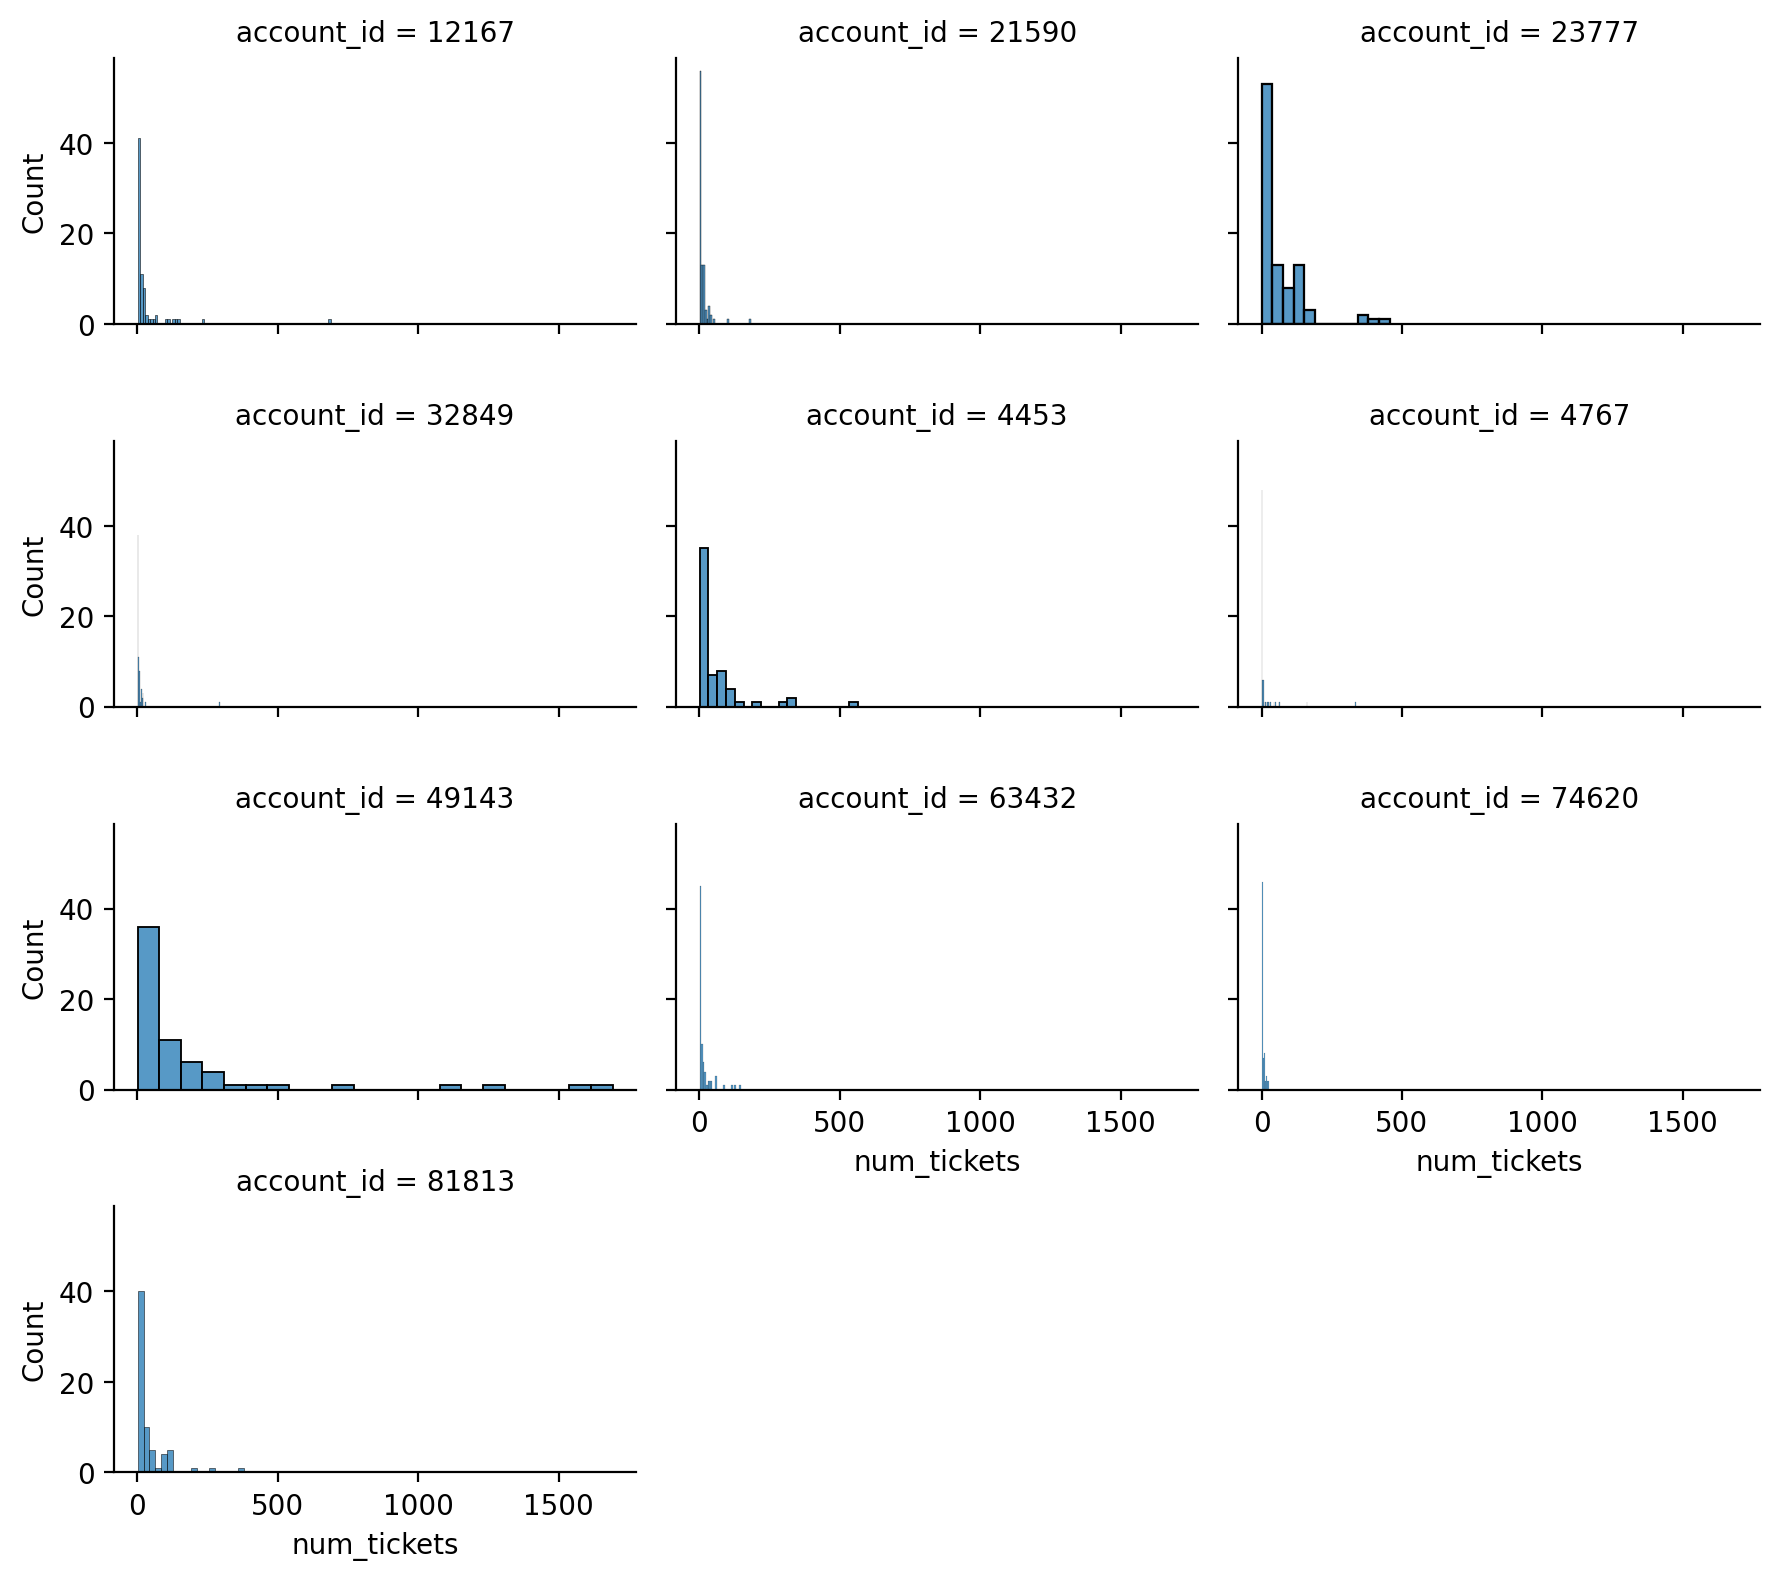

In [172]:
g = sns.FacetGrid(data=client_label_agg_cnt[client_label_agg_cnt.account_id.isin(top_client_ids[::-1])], 
                  col="account_id", col_wrap=3, aspect=1.5, height=2)
g.map(sns.histplot, "num_tickets")
plt.show()

The distribution of the number of tickets per contact reason is skewed for all top10 clients. Due to the nature of ticket requests data, very few of them are quite frequent and the rest of them just happens very rare.

In [176]:
client_label_agg_cnt[client_label_agg_cnt.num_tickets <= 10].account_id.unique().shape[0]

66

Almost 99% of clients have less than or equal to 10 tickets per contact reason and it seems quite interesting to handle them if possible in a PoC.

In [201]:
client_label_agg_cnt.sort_values("num_tickets", ascending=False).head(15)

,account_id,contact_reason,num_tickets
925,49143,"""PDF::Poor On Arrival""",1692
944,49143,"""WISMO::Not Despatched""",1587
923,49143,"""PDF::Failed After Planting""",1289
940,49143,"""WISMO::Delivered""",1140
945,49143,"""WISMO::On the way""",713
458,32461,"""Other""",692
22,12167,"""N/A""",688
1834,89195,"""Return""",633
1836,89195,"""Shipping::WISMO""",614
737,4453,"""Other""",563


Top 10 popular contact reasons per clients. Amongh those reasons we observe labels such as "Other", "N/A" and "Spam" that are not specific.

In [181]:
client_label_agg_cnt.sort_values("num_tickets", ascending=False).tail(10)

,account_id,contact_reason,num_tickets
1439,70399,"""Order::Shipping inquiries""",1
1444,70399,"""Payment::Refund""",1
624,37330,"""Shipping::Lost Shipment::USPS""",1
1446,70399,"""Payment::Shopify Chargeback""",1
1448,70399,"""Product::Inquiry""",1
1449,70399,"""Product::Testers""",1
1450,70399,"""Return::DHL return""",1
1451,70399,"""Review::Trustpilot""",1
1454,70399,"""Tracking::Delivered not received""",1
1933,92372,"""Support::Rewards/Points""",1


Rare examples of contact reasons per client

In [194]:
label_stats = client_label_agg_cnt.groupby("account_id")["num_tickets"].describe() \
                                  .sort_values("count", ascending=False)

In [200]:
label_stats.sample(10)

,count,mean,std,min,25%,50%,75%,max
account_id,,,,,,,,
37330,26.0,18.230769,48.441559,1.0,2.00,3.0,5.00,217.0
66034,1.0,1.000000,NaN,1.0,1.00,1.0,1.00,1.0
32849,69.0,9.550725,35.255177,1.0,1.00,3.0,7.00,294.0
92372,39.0,3.666667,4.675430,1.0,1.00,2.0,3.00,23.0
8306,38.0,24.552632,58.119494,1.0,2.25,4.0,18.75,318.0
61061,46.0,26.804348,42.261419,1.0,5.00,13.0,28.75,256.0
85684,4.0,11.250000,10.719919,1.0,2.50,11.5,20.25,21.0
29372,35.0,16.742857,19.953391,1.0,2.00,9.0,23.00,75.0
62422,37.0,2.648649,2.030547,1.0,1.00,2.0,3.00,8.0


Sample list of target distribution statistics per client

In [198]:
label_stats[label_stats["75%"] <= 10].shape[0]

33

Almost half of the clients have only a 25% of the number of labels having more than 10 tickets. Those clients have extremely skewed distribution of labels and it also a challenge to address that.

## Email sentence embeddings info